<a href="https://colab.research.google.com/github/Chinmay-1907/Alzheimer-s_Severity_Prediction_Model-/blob/main/Alzhemers_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [19]:
import os
import tensorflow as tf
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Download dataset using API
dataset_root = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

# 2. Set paths to both subfolders
original_path = os.path.join(dataset_root, "OriginalDataset")
augmented_path = os.path.join(dataset_root, "AugmentedAlzheimerDataset")

# 3. Create a list of file paths and labels from both directories
def collect_image_paths_and_labels(base_path):
    filepaths = []
    labels = []
    for class_name in os.listdir(base_path):
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):  # Ensure it's a folder
            for fname in os.listdir(class_path):
                if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                    filepaths.append(os.path.join(class_path, fname))
                    labels.append(class_name)
    return filepaths, labels

# 4. Combine both Original and Augmented datasets
orig_paths, orig_labels = collect_image_paths_and_labels(original_path)
aug_paths, aug_labels = collect_image_paths_and_labels(augmented_path)

all_paths = orig_paths + aug_paths
all_labels = orig_labels + aug_labels

# 5. Create DataFrame (like ideal code)
df = pd.DataFrame({
    "filepaths": all_paths,
    "labels": all_labels
})

print("Total Images:", len(df))
print("Classes:")
print(df["labels"].value_counts())

Total Images: 40384
Classes:
labels
NonDemented         12800
VeryMildDemented    11200
MildDemented         9856
ModerateDemented     6528
Name: count, dtype: int64


In [20]:
df.shape

(40384, 2)

In [21]:
from sklearn.model_selection import train_test_split

# Train + Val - Test (30% of all data)
trainval_df, test_df = train_test_split(df, test_size=0.3, random_state= 10, stratify=df["labels"])

# Now split trainval into training and validation (20% of trainval → validation)
train_df, val_df = train_test_split(trainval_df, test_size=0.2, random_state= 10, stratify=trainval_df["labels"])

What is flow_from_dataframe()?

Takes a pandas DataFrame where: What we have now
- One column has full image ***File Paths***
- Another has the labels

Its then able to
- Loads the image from disk (Memory Efficient)
- Applies resizing, augmentation, preprocessing, etc.
- Batches them automatically for training
- Assigns labels based on the column you specify


🗂 DataFrame (paths + labels) → 🍽️ Batches of preprocessed images ready for the model


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Use built-in preprocessing from MobileNetV2 (scale images to expected range)
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [23]:
target_size = (224, 224)
batch_size = 32

train = image_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=target_size,
    color_mode='rgb',
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

Found 22614 validated image filenames belonging to 4 classes.


In [24]:

val = image_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepaths",
    y_col="labels",
    target_size=target_size,
    color_mode='rgb',
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

Found 5654 validated image filenames belonging to 4 classes.


In [25]:
test = image_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=target_size,
    color_mode='rgb',
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)


Found 12116 validated image filenames belonging to 4 classes.


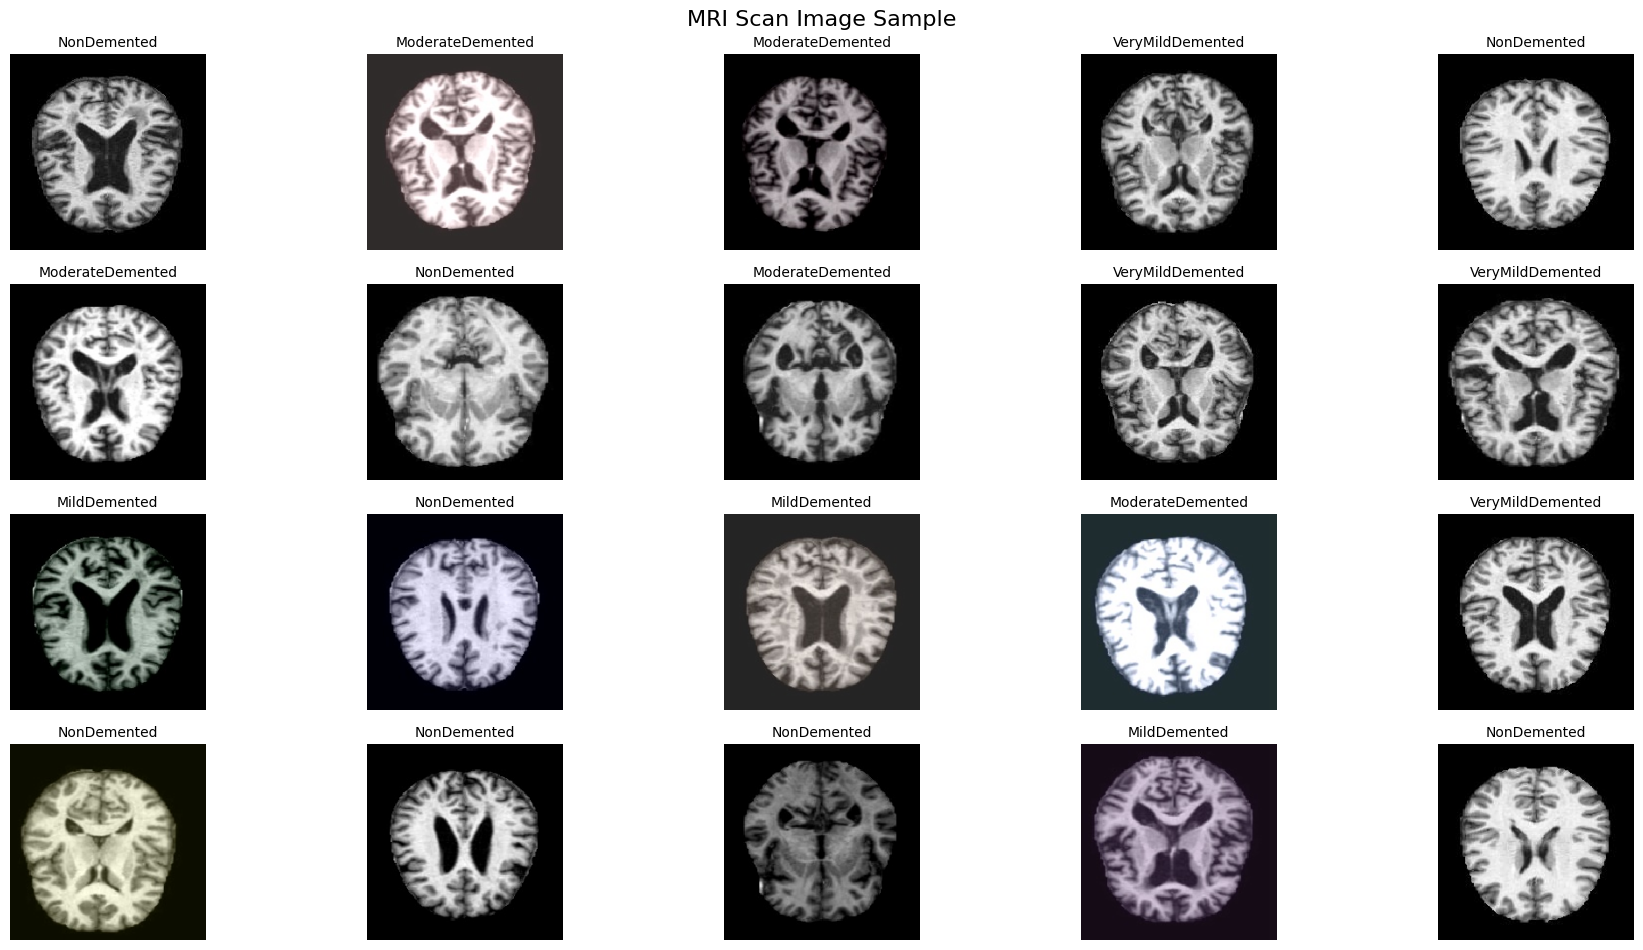

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_images(generator, title="MRI Scan Image Sample"):
    class_indices = generator.class_indices
    classes = list(class_indices.keys())

    # Fetch one batch of images and labels
    images, labels = next(generator)

    plt.figure(figsize=(18, 12))
    num_images = min(20, len(images))

    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2  # normalization ([-1,1] → [0,1])
        plt.imshow(image)
        label_index = np.argmax(labels[i])
        class_name = classes[label_index]
        plt.title(class_name, fontsize=10)
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Show 25 images from the training generator
show_sample_images(train)


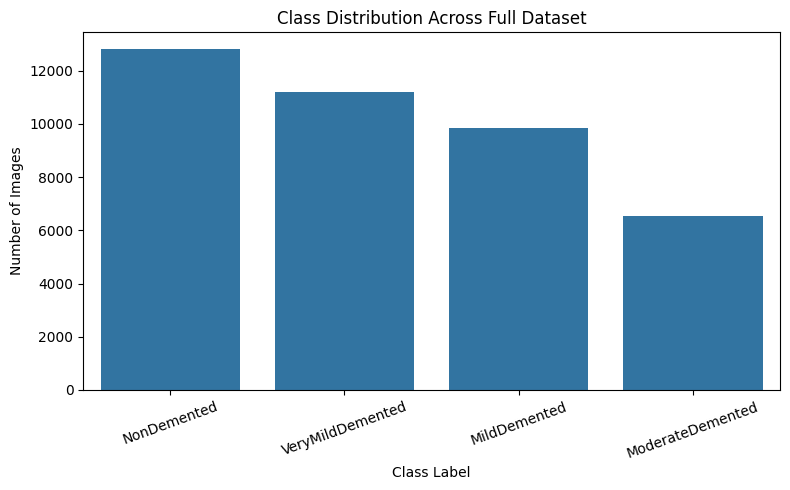

In [27]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="labels", order=df["labels"].value_counts().index)
plt.title("Class Distribution Across Full Dataset")
plt.xticks(rotation=20)
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


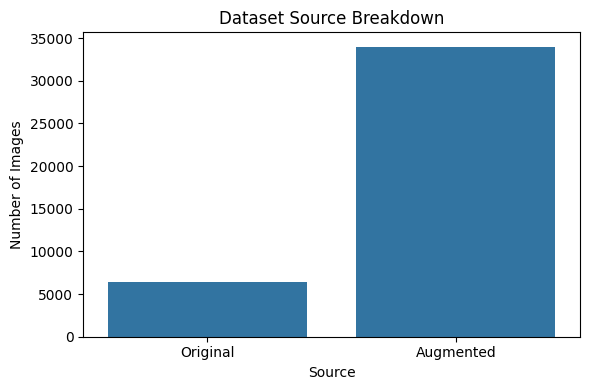

In [28]:
def get_source(filepath):
    if "OriginalDataset" in filepath:
        return "Original"
    elif "AugmentedAlzheimerDataset" in filepath:
        return "Augmented"
    else:
        return "Unknown"

df["source"] = df["filepaths"].apply(get_source)

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="source")
plt.title("Dataset Source Breakdown")
plt.xlabel("Source")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


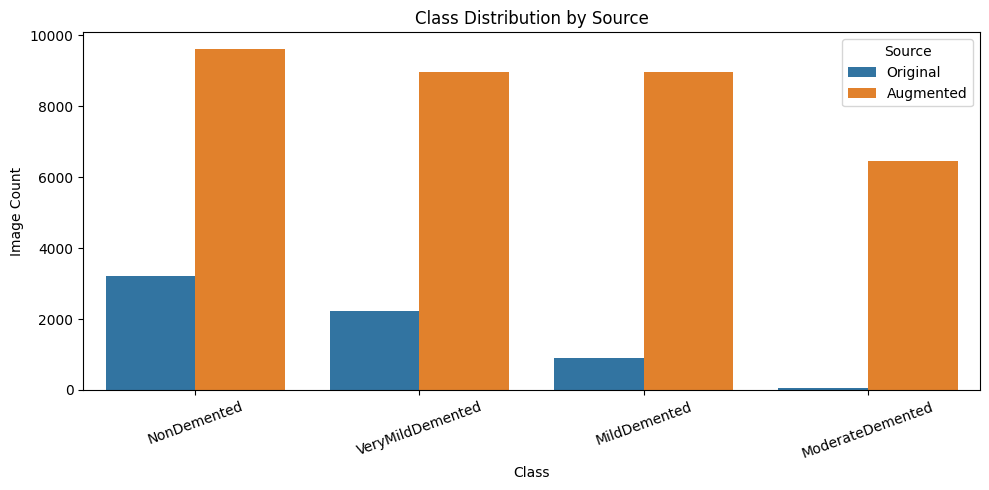

In [29]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="labels", hue="source", order=df["labels"].value_counts().index)
plt.title("Class Distribution by Source")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=20)
plt.legend(title="Source")
plt.tight_layout()
plt.show()


## Building the Model

In [30]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Block 1
    layers.Conv2D(128, (8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),

    # Block 2
    layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((3, 3)),

    # Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # Block 4
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 5
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 6
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Classification head
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 output classes
])


In [31]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 12, 12, 512)         │           2,0

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',       # Watch validation loss
    patience=3,               # Stop if it doesn't improve for 3 epochs
    restore_best_weights=True,  # Go back to the best model (not last epoch)
    verbose=1
)


In [34]:
import time

# Start the timer
start_time = time.time()

# Train the model
history = model.fit(
    train,
    epochs=40,
    validation_data=val,
    callbacks=[early_stop],
    verbose=1
)

# End the timer
end_time = time.time()

# Calculate duration
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ({training_time / 60:.2f} minutes)")


Epoch 1/40
707/707 ━━━━━━━━━━━━━━━━━━━━ 115s 152ms/step - accuracy: 0.3504 - loss: 1.7514 - val_accuracy: 0.5340 - val_loss: 1.0558
Epoch 2/40
707/707 ━━━━━━━━━━━━━━━━━━━━ 106s 150ms/step - accuracy: 0.4884 - loss: 1.0993 - val_accuracy: 0.5994 - val_loss: 0.9119
Epoch 3/40
707/707 ━━━━━━━━━━━━━━━━━━━━ 105s 149ms/step - accuracy: 0.5687 - loss: 0.9369 - val_accuracy: 0.6392 - val_loss: 0.8055
Epoch 4/40
707/707 ━━━━━━━━━━━━━━━━━━━━ 107s 152ms/step - accuracy: 0.6157 - loss: 0.8313 - val_accuracy: 0.6625 - val_loss: 0.7321
Epoch 5/40
707/707 ━━━━━━━━━━━━━━━━━━━━ 114s 161ms/step - accuracy: 0.6469 - loss: 0.7524 - val_accuracy: 0.7106 - val_loss: 0.6541
Epoch 6/40
707/707 ━━━━━━━━━━━━━━━━━━━━ 106s 150ms/step - accuracy: 0.6955 - loss: 0.6795 - val_accuracy: 0.7351 - val_loss: 0.5980
Epoch 7/40
707/707 ━━━━━━━━━━━━━━━━━━━━ 106s 150ms/step - accuracy: 0.7319 - loss: 0.5975 - val_accuracy: 0.7573 - val_loss: 0.5559
Epoch 8/40
707/707 ━━━━━━━━━━━━━━━━━━━━ 107s 152ms/step - accuracy: 0.7847 -

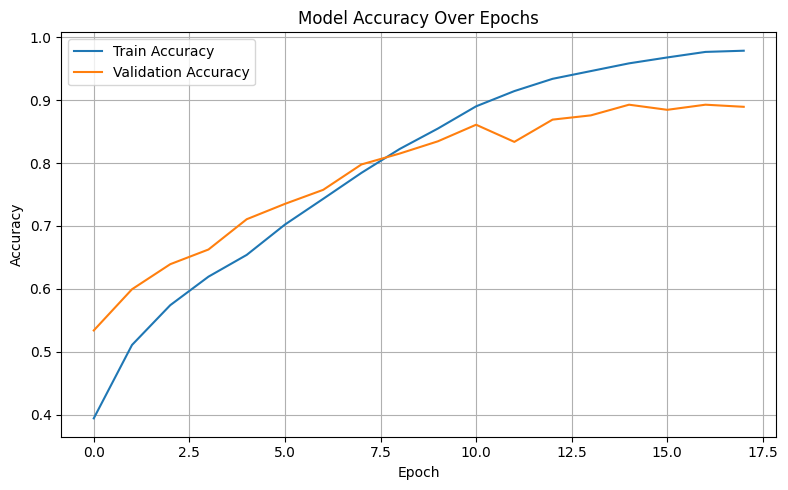

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


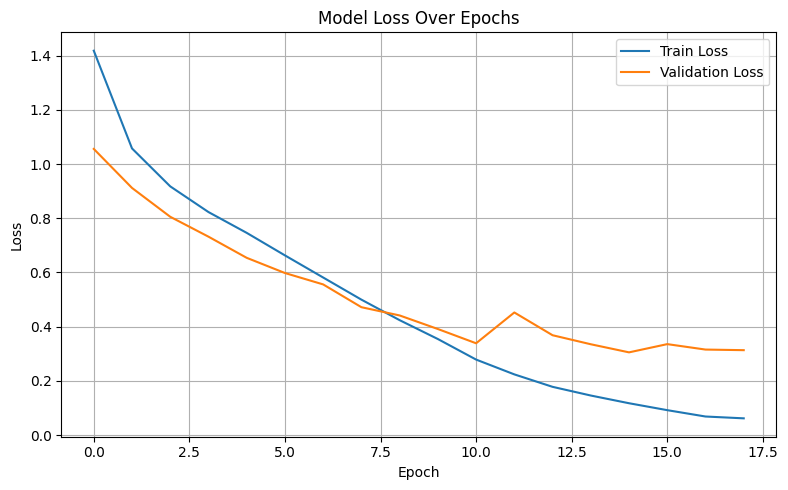

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Train Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Final Train Accuracy: 0.9784
Final Validation Accuracy: 0.8893


In [38]:
test_loss, test_accuracy = model.evaluate(test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


379/379 ━━━━━━━━━━━━━━━━━━━━ 95s 250ms/step - accuracy: 0.8939 - loss: 0.3073
Test Loss: 0.3057
Test Accuracy: 0.8948


In [39]:
import numpy as np

# Get class indices (e.g., {'Mild Demented': 0, ...})
class_indices = test.class_indices
class_names = list(class_indices.keys())

# Reverse the mapping: 0 → 'Mild Demented', etc.
index_to_class = {v: k for k, v in class_indices.items()}

# Predict
pred_probs = model.predict(test)
pred_labels = np.argmax(pred_probs, axis=1)
pred_class_names = [index_to_class[i] for i in pred_labels]


379/379 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step


In [40]:
true_labels = test.classes  # Numeric form
true_class_names = [index_to_class[i] for i in true_labels]

In [41]:
from sklearn.metrics import classification_report

print(classification_report(true_class_names, pred_class_names, target_names=class_names))


                  precision    recall  f1-score   support

    MildDemented       0.88      0.91      0.89      2957
ModerateDemented       0.99      0.99      0.99      1959
     NonDemented       0.90      0.89      0.89      3840
VeryMildDemented       0.85      0.83      0.84      3360

        accuracy                           0.89     12116
       macro avg       0.90      0.91      0.90     12116
    weighted avg       0.89      0.89      0.89     12116



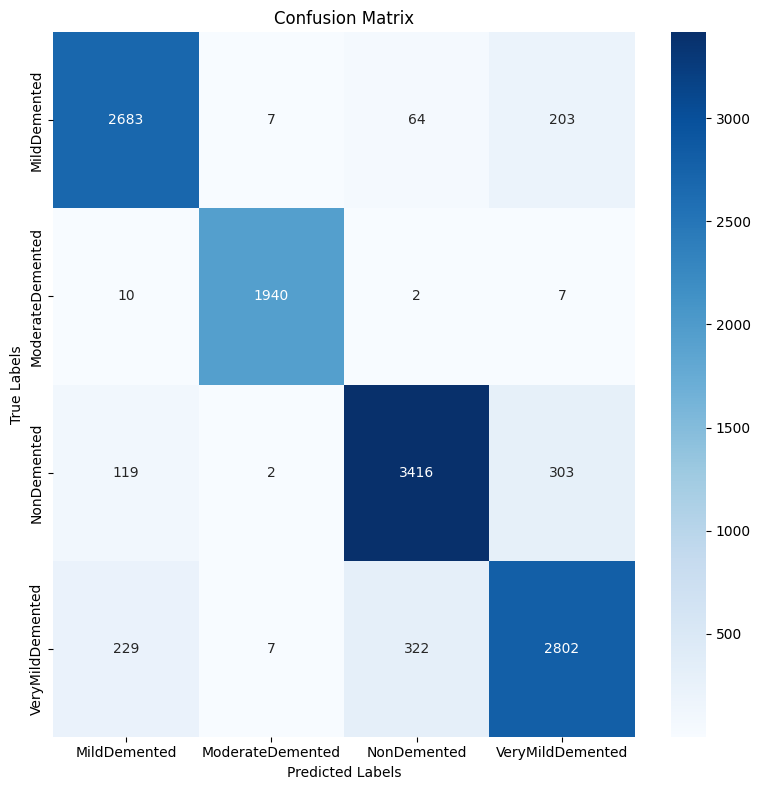

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_class_names, pred_class_names, labels=class_names)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Future Outlook

Transfer Learning with Pretrained Models 🧠: Instead of training from scratch, leverage models pretrained
  - MobileNetV2, VGG19, ResNet50

Ensemble Models 🧠🧠🧠
Train multiple models:
  - CNN + MobileNet + VGG → combine their predictions
  - Use majority voting or probability averaging

Try Larger Dataset - More Balanced cleaner dataset

Other augmentation and filtering methods for better learning examples